Import libraries

In [2]:
import os 
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from pprint import pprint
import seaborn as sns
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from utils import load_pickle, pickle_data, load_json, compute_MS_sim

import torch
from sklearn.metrics.pairwise import cosine_similarity

Settings

In [3]:
data_folder = "/data/rbg/users/klingmin/projects/MS_processing/data/"
splits_folder = "/data/rbg/users/klingmin/projects/MS_processing/data_splits"
IF_scores_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/baseline_models/best_models"
model_results_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/baseline_models/best_models"
cache_folder = "./cache/ls_plots"
ls_plots_folder = os.path.join("./cache/ls_plots/plots")
if not os.path.exists(ls_plots_folder): os.makedirs(ls_plots_folder)

print(os.listdir(IF_scores_folder))
datasets = ["nist2023", "canopus", "massspecgym"]
splits = ["random", "inchikey_vanilla", "scaffold_vanilla", "LS"]
models = ["binned_", "formula_", "MS_"]

colors = ["#575761", "#648381", "#98B9AB", "#9BC995"][::-1]

split_mapping = {"inchikey_vanilla": "InChIKey Split",
                 "scaffold_vanilla": "Scaffold Split",
                 "LS": "LS Split"}

['massspecgym', 'massspecgym_sieved', 'nist2023', 'nist2023_sieved', 'canopus']


Load up the data for each dataset

In [17]:
dataset_info = {} 

canopus = load_pickle(os.path.join(data_folder, "canopus", "canopus_w_mol_info_w_frag_CF_preds.pkl"))
canopus = {str(r["id_"]) : r for r in canopus}
print("Done loading canopus")

massspecgym = load_pickle(os.path.join(data_folder, "massspecgym", "massspecgym_w_mol_info_w_frag_CF_preds.pkl"))
massspecgym = {str(r["id_"]) : r for r in massspecgym}
print("Done loading MSG")

nist2023 = load_pickle(os.path.join(data_folder, "nist2023", "nist2023_w_mol_info_w_frag_CF_preds.pkl"))
nist2023 = {r["id_"] : r for r in nist2023}
print("Done loading NIST2023")

dataset_info["canopus"] = canopus
dataset_info["massspecgym"] = massspecgym
dataset_info["nist2023"] = nist2023

Done loading canopus
Done loading MSG
Done loading NIST2023


In [9]:
def get_peaks_count(peaks):

    peaks_no_noise = [p for p in peaks if p["comment"]["f_pred"] != ""]

    return len(peaks_no_noise)/ len(peaks)

In [10]:
dataset_stats_info = {}

canopus_stats = {k: get_peaks_count(v["peaks"]) for k,v in canopus.items()}
massspecgym_stats = {k: get_peaks_count(v["peaks"]) for k,v in massspecgym.items()}

dataset_stats_info["canopus"] = canopus_stats
dataset_stats_info["massspecgym"] = massspecgym_stats


NameError: name 'canopus' is not defined

`` Load up the representation against the id ``

In [25]:
all_rep = {} 

for dataset in datasets:

    # if dataset == "nist2023": continue

    all_rep[dataset] = {} 

    for key, rec in dataset_info[dataset].items():
        
        inchikey = rec["inchikey_original"][:14]
        peaks = set([p["comment"]["f_pred"] for p in rec["peaks"]])
        peaks.discard("")

        rep = "_".join(sorted(peaks))

        if rep not in all_rep[dataset]: all_rep[dataset][rep] = [] 
        all_rep[dataset][rep].append((key, inchikey))

Load up the splits

In [20]:
all_splits = {} 

for dataset in datasets:
    # if dataset == "nist2023": continue

    all_splits[dataset] = {} 

    for split in splits: 

        current_filepath = os.path.join(splits_folder, dataset, "splits", f"{split}.json")
        assert os.path.exists(current_filepath)

        split_ids = load_json(current_filepath)
        train, val, test = split_ids["train"], split_ids["val"], split_ids["test"]
        train = [t.replace(".pkl", "") for t in train]
        val = [t.replace(".pkl", "") for t in val]
        test = [t.replace(".pkl", "") for t in test]

        all_splits[dataset][split] = {"train": train + val,
                                      "test": test}

`` Sanity check: Check "similarity" of LS split against other splits ``

In [9]:
splits_overlap_rate = {} 

for dataset in datasets: 

    if dataset == "nist2023": continue
    for split in splits: 
        
        if split == "LS": continue 

        split_train = all_splits[dataset][split]["train"]
        LS_train = all_splits[dataset]["LS"]["train"]

        n_overlap = len(set(split_train).intersection(set(LS_train)))
        expected_overlap = int(len(split_train) * len(LS_train) / (len(all_splits[dataset][split]["train"]) + len(all_splits[dataset][split]["test"])))
        percent_diff = (expected_overlap - n_overlap) / expected_overlap * 100

        print(n_overlap, expected_overlap, percent_diff, split, dataset)
        print()

10615 11649 8.876298394711993 random canopus

10633 11689 9.034134656514672 inchikey_vanilla canopus

10782 11690 7.767322497861421 scaffold_vanilla canopus

76191 84817 10.170130987891577 random massspecgym

76407 85008 10.117871259175606 inchikey_vanilla massspecgym

76855 85009 9.591925560822972 scaffold_vanilla massspecgym



`` Hypothesis 1: OOV rate ``

In [22]:
splits_oov_rate = {} 

for dataset in datasets:

    # if dataset == "nist2023": continue
    splits_oov_rate[dataset] = {} 

    for split in splits: 
        print

        train_ids = all_splits[dataset][split]["train"]
        train_CF = set([p["comment"]["f_pred"] for i in train_ids for p in dataset_info[dataset][i]["peaks"]])

        oov = []

        for t in all_splits[dataset][split]["test"]:

            test_peaks = [p["comment"]["f_pred"] for p in dataset_info[dataset][t]["peaks"]]
            test_peaks = [p for p in test_peaks if p != ""]
            if len(test_peaks) == 0: 
                test_oov = 100
            else:
                test_oov = len(set(test_peaks).difference(train_CF)) / len(test_peaks) * 100

            oov.append(test_oov)

        splits_oov_rate[dataset][split] = oov

        print(dataset, split, np.mean(oov), np.std(oov))
        
        print()

nist2023 random 0.8199246545060002 7.890810623967037

nist2023 inchikey_vanilla 2.2412316716874665 10.895377601308908

nist2023 scaffold_vanilla 2.1168749004481144 10.426351363188296

nist2023 LS 2.322661460089833 11.617316922664353

canopus random 3.6660718599636923 12.254963553143208

canopus inchikey_vanilla 4.845355716376836 13.886706524364149

canopus scaffold_vanilla 4.642251721785458 13.382136386575695

canopus LS 6.872792606477782 18.448232789564557

massspecgym random 1.8896220814092122 9.399569034895169

massspecgym inchikey_vanilla 5.2345988913621255 13.353291053590729

massspecgym scaffold_vanilla 6.379180053715402 15.356986253395734

massspecgym LS 9.252196018690316 18.571638436863054



/tmp/ipykernel_3226598/531356992.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_3226598/531356992.py:36: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_3226598/531356992.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["Group"], fontsize = 15)


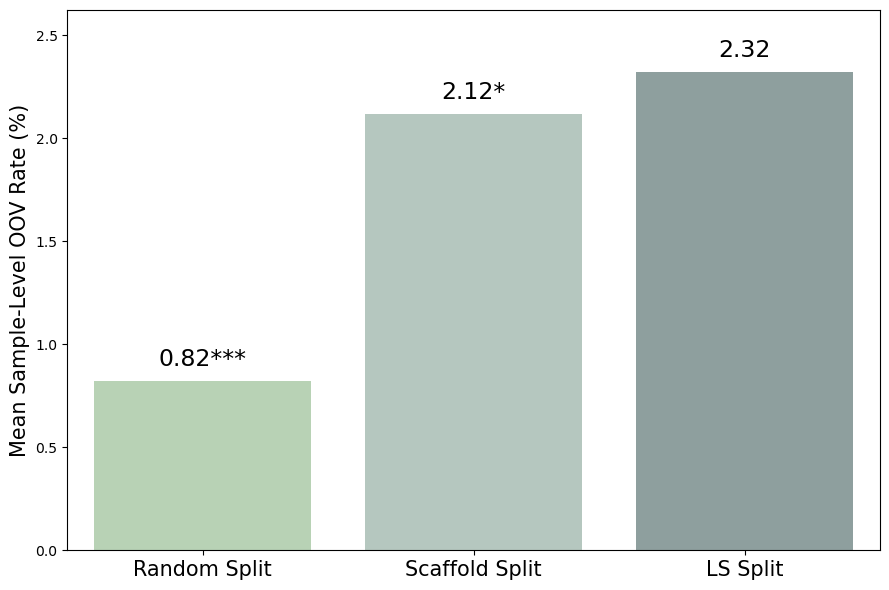

/tmp/ipykernel_3226598/531356992.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_3226598/531356992.py:36: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_3226598/531356992.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["Group"], fontsize = 15)


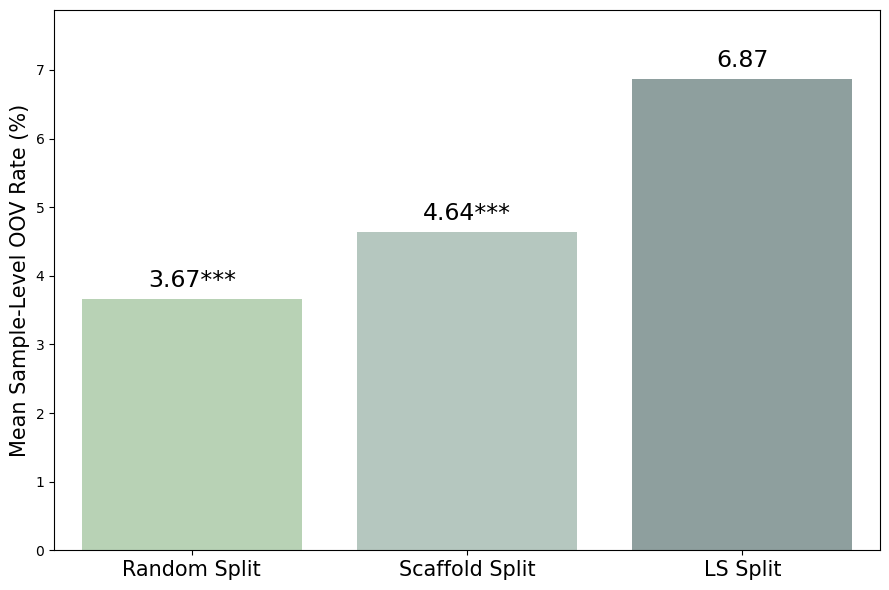

/tmp/ipykernel_3226598/531356992.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_3226598/531356992.py:36: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_3226598/531356992.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["Group"], fontsize = 15)


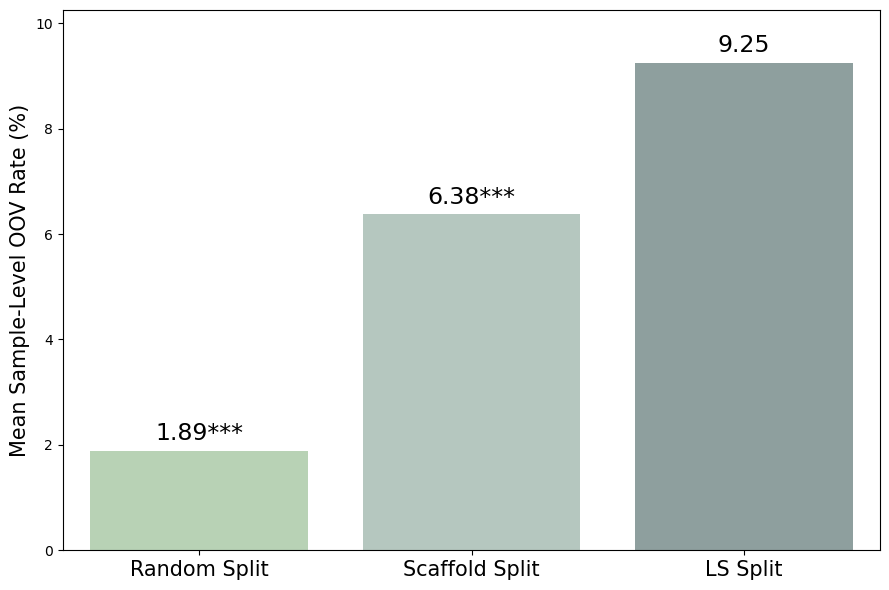

In [23]:
# Extract values
for dataset in datasets: 

    # if dataset == "nist2023": continue 

    oov_ls = splits_oov_rate[dataset]["LS"]
    oov_scaffold = splits_oov_rate[dataset]["scaffold_vanilla"]
    # oov_inchikey = splits_oov_rate[dataset]["inchikey_vanilla"]
    oov_random = splits_oov_rate[dataset]["random"]

    # Create flat dataframe
    data = {
        "Group": ["LS Split"] * len(oov_ls) +
                ["Scaffold Split"] * len(oov_scaffold) +
                # ["InChIKey Split"] * len(oov_inchikey) +
                ["Random Split"] * len(oov_random),
        # "OOV": oov_ls + oov_scaffold + oov_inchikey + oov_random
        "OOV": oov_ls + oov_scaffold + oov_random
    }
    df = pd.DataFrame(data)

    # Calculate mean OOV for each group
    summary_df = df.groupby("Group")["OOV"].mean().reset_index()
    # summary_df["Group"] = pd.Categorical(summary_df["Group"], categories=[
    #     "Random Split", "InChIKey Split", "Scaffold Split", "LS Split"
    # ], ordered=True)
    summary_df["Group"] = pd.Categorical(summary_df["Group"], categories=[
        "Random Split", "Scaffold Split", "LS Split"
    ], ordered=True)
    summary_df = summary_df.sort_values("Group")

    # Plot
    plt.figure(figsize=(9, 6))

    # Draw bar plot
    ax = sns.barplot(
        data=summary_df,
        x="Group",
        y="OOV", palette = colors, alpha = 0.75)

    # Overlay red curve (line connecting bar tops)
    x = np.arange(len(summary_df))
    y = summary_df["OOV"].values

    # Add values and p-values
    x = np.arange(len(summary_df))
    y = summary_df["OOV"].values
    group_names = summary_df["Group"].values

    # Statistical tests
    p_values = {}
    p_values["Random Split"] = ttest_ind(oov_ls, oov_random, equal_var=False).pvalue
    # p_values["InChIKey Split"] = ttest_ind(oov_ls, oov_inchikey, equal_var=False).pvalue
    p_values["Scaffold Split"] = ttest_ind(oov_ls, oov_scaffold, equal_var=False).pvalue

    for i, (val, group) in enumerate(zip(y, group_names)):
        
        if group != "LS Split":
            pval = p_values[group]
            if pval < 0.001:
                p_text = "***"
            elif pval < 0.01:
                p_text = "**"
            elif pval < 0.05:
                p_text = "*"
            else:
                p_text = "n.s."
        
        else: p_text = ""
        add_text = 0.1
        if dataset == "nist2023": add_text = 0.05
        ax.text(i, val + add_text, f"{val:.2f}" + p_text, ha="center", va="bottom", fontsize=17)

    # Final plot customizations
    ax.set_ylabel("Mean Sample-Level OOV Rate (%)", fontsize = 15)
    add = 1.0
    if dataset == "nist2023": add = 0.3
    ax.set_ylim(0, max(y) + add)
    ax.set_xlabel("")
    ax.set_xticklabels(summary_df["Group"], fontsize = 15)
    plt.grid(False)
    plt.tight_layout()
    output_path = os.path.join(ls_plots_folder, f"{dataset}_oov_no_inchikey.jpg")
    plt.savefig(output_path, bbox_inches="tight")
    plt.show()

`` Hypothesis 2 ``

So we have observed that LS is linked to high OOV rate but what about those with low OOV, why are they deemed to be difficult by the model

In [34]:
for dataset in datasets: 

    current_info = dataset_info[dataset]
    unique_mol = set([r["inchikey_original"][:14] for r in current_info.values()])
    n_unique_mol = len(unique_mol)
    n_unique_spectra = len(current_info)
    n_unique_represent = len(all_rep[dataset])

    print(dataset, n_unique_mol, n_unique_spectra, n_unique_represent)

nist2023 27265 1038445 880763
canopus 8552 19685 18357
massspecgym 17002 120956 89329


In [27]:
all_rep_sep = {} 

for dataset in datasets: 

    all_rep_sep[dataset] = {} 

    current_rep = all_rep[dataset]
    rep_sieved_single = {} 
    rep_sieved_same = {}
    rep_sieved_diff = {}

    for rep, list in current_rep.items():

        if len(list) == 1: 
            rep_sieved_single[rep] = list
            continue
        inchikey_list = [r[1] for r in list]
        if len(set(inchikey_list)) == 1: 
            rep_sieved_same[rep] = list 
        else: 
            rep_sieved_diff[rep] = list 
    
    all_rep_sep[dataset] = {"single": rep_sieved_single, 
                            "same": rep_sieved_same,
                            "diff": rep_sieved_diff}
    
    multiple = len(rep_sieved_diff) + len(rep_sieved_same)
    percent = len(rep_sieved_diff) / multiple * 100

    print(dataset, percent)

nist2023 29.504365161201623
canopus 21.291866028708135
massspecgym 5.006461494280381


In [55]:
for dataset in datasets: 

    reps_sep = all_rep_sep[dataset]
    singles = [p[0] for r in reps_sep["single"].values() for p in r]
    same = [p[0] for r in reps_sep["same"].values() for p in r]
    diff = [p[0] for r in reps_sep["diff"].values() for p in r]

    print(len(diff))
    total = len(same) + len(diff) + len(singles)
    percent_same = len(same) / total * 100 
    percent_diff = len(diff) / total * 100 

    print(dataset, percent_same)

106758
nist2023 10.50724881914786
911
canopus 4.241808483616967
6739
massspecgym 37.849300572108866


`` Look at the distribution of these samples ``

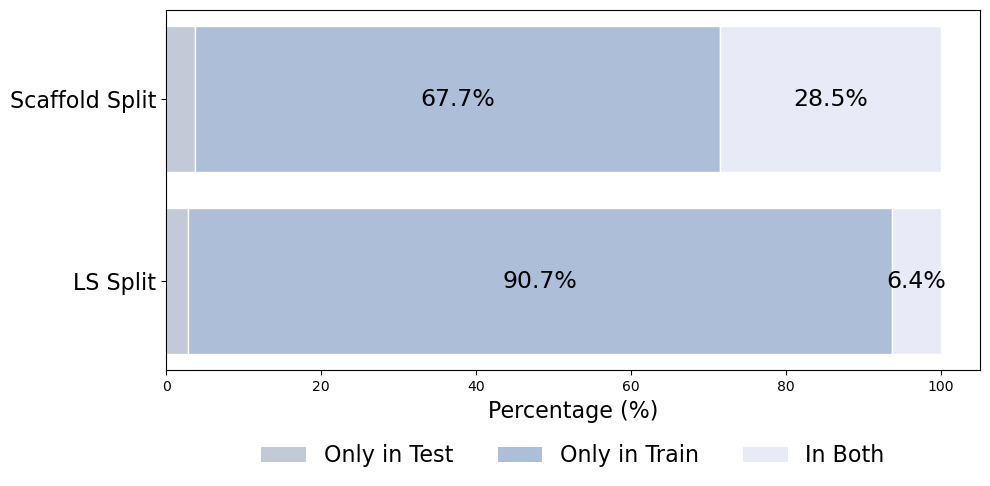

In [41]:
import matplotlib.pyplot as plt

colors = {
    "only_train": "#ACBED8",     
    "only_test": "#C1CAD6",         # orangish
    "both_test_train": "#E8EBF7"    # bluish
}

splits_to_plot = ["LS", "scaffold_vanilla"]
bar_data = []

for dataset in datasets:

    if dataset != "nist2023": continue

    for split in splits_to_plot:

        only_test, only_train, both_test_train = 0, 0, 0
        missing = 0

        confusing_rep = all_rep_sep[dataset]["diff"]
        train_ids = all_splits[dataset][split]["train"]
        test_ids = all_splits[dataset][split]["test"]

        for _, sets in confusing_rep.items():
            sets = [s[0] for s in sets]

            in_train = any(i in train_ids for i in sets)
            in_test = any(i in test_ids for i in sets)

            if in_train and in_test:
                both_test_train += 1
            elif in_train:
                only_train += 1
            elif in_test:
                only_test += 1
            else:
                missing += 1

        total = only_test + only_train + both_test_train
        if total == 0:
            continue

        pct_only_train = 100 * only_train / total
        pct_only_test = 100 * only_test / total
        pct_both = 100 * both_test_train / total

        bar_data.append({
            "dataset": dataset,
            "split": split,
            "only_train": pct_only_train,
            "only_test": pct_only_test,
            "both": pct_both
        })

    # PLOT all splits for this dataset
    fig, ax = plt.subplots(figsize=(10, 5))

    split_labels = [split_mapping[entry["split"]] for entry in bar_data if entry["dataset"] == dataset]
    y_pos = range(len(split_labels))

    # Extract each segment across splits
    only_train_vals = [entry["only_train"] for entry in bar_data if entry["dataset"] == dataset]
    only_test_vals = [entry["only_test"] for entry in bar_data if entry["dataset"] == dataset]
    both_vals = [entry["both"] for entry in bar_data if entry["dataset"] == dataset]

    # Plot stacked bars
    left = [0] * len(split_labels)
    ax.barh(y_pos, only_test_vals, left=left, color=colors["only_test"], edgecolor="white", label="Only in Test")
    left = [l + v for l, v in zip(left, only_test_vals)]
    ax.barh(y_pos, only_train_vals, left=left, color=colors["only_train"], edgecolor="white", label="Only in Train")
    left = [l + v for l, v in zip(left, only_train_vals)]
    ax.barh(y_pos, both_vals, left=left, color=colors["both_test_train"], edgecolor="white", label="In Both")

    # Labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(split_labels, fontsize=16)
    ax.set_xlim(0, 105)
    ax.set_xlabel("Percentage (%)", fontsize=16)
    ax.grid(False)

    # Optional: Show values in bar
    for i, (a, b, c) in enumerate(zip(only_test_vals, only_train_vals, both_vals)):
        if a > 5:
            ax.text(a / 2, i, f"{a:.1f}%", ha="center", va="center", fontsize=17)
        if b > 5:
            ax.text(a + b / 2, i, f"{b:.1f}%", ha="center", va="center", fontsize=17)
        if c > 5:
            ax.text(a + b + c / 2, i, f"{c:.1f}%", ha="center", va="center", fontsize=17)

    legend_elements = [
        Patch(facecolor=colors["only_test"], label="Only in Test"),
        Patch(facecolor=colors["only_train"], label="Only in Train"),
        Patch(facecolor=colors["both_test_train"], label="In Both")
    ]

    ax.legend(handles=legend_elements,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=3,
            fontsize=16,
            frameon=False)
    
    plt.tight_layout()

    # Save figure
    instrument_output_path = os.path.join(ls_plots_folder, f"{dataset}_dist_confusing_samples_no_inchikey.jpg")
    plt.savefig(instrument_output_path, bbox_inches="tight")
    plt.show()

    # Reset for next dataset
    bar_data = []

Look at the predictions of samples of different molecules but same formula set

In [20]:
output_path = os.path.join(cache_folder, "sim_ambiguous_cases.csv")
if not os.path.exists(output_path):

    record = [] 

    for dataset in datasets:

        dataset_results_folder = os.path.join(model_results_folder,dataset)

        for model in models:

            current_results_folder = [os.path.join(dataset_results_folder, f) for f in os.listdir(dataset_results_folder) if model in f]
            
            for split in splits:
                
                similarity_pred, similarity_GT, MS_similarity = [], [], []
                
                reps_sep = all_rep_sep[dataset]["diff"]

                # model_results_folder
                results_path = [f for f in current_results_folder if split in f]
                assert len(results_path) == 1 
                results_path = results_path[0]

                results = load_pickle(os.path.join(results_path, "test_results.pkl"))
                results = {(str(k.item()) if type(k) == torch.Tensor else str(k)) : v for k, v in results.items()}

                for k, v in reps_sep.items():
                    
                    remaining = [(id_,inch) for (id_, inch) in v if id_ in results]
                    if len(set([r[1] for r in remaining])) == 1: continue 

                    pred_list = [results[id_]["pred"] for (id_, _) in remaining]
                    GT_list = [results[id_]["GT"] for (id_, _) in remaining]

                    if len(pred_list) < 2 or len(GT_list) < 2: continue 

                    similarity_matrix = cosine_similarity(pred_list)
                    triu_indices = np.triu_indices_from(similarity_matrix, k=1)

                    # Compute mean of upper triangle similarities
                    mean_similarity_pred = similarity_matrix[triu_indices].mean().item()
                    mean_similarity_GT = cosine_similarity(GT_list)[triu_indices].mean().item()

                    similarity_pred.append(mean_similarity_pred)
                    similarity_GT.append(mean_similarity_GT)

                    # Get similarity of the MS 
                    MS_similarity_list = []
                    for i in range(len(remaining)):

                        for j in range(i+1, len(remaining)):

                            sim = compute_MS_sim(dataset_info[dataset][remaining[i][0]], dataset_info[dataset][remaining[j][0]])
                            MS_similarity_list.append(sim)

                    MS_similarity.append(np.mean(MS_similarity_list).mean())

                record.append([dataset, model, split, np.mean(MS_similarity).item(), np.mean(similarity_pred).item(), np.mean(similarity_GT).item()])

    record = pd.DataFrame(record, columns = ['dataset', 'model', 'split', 'MS sim', 'FP pred sim', 'FP sim'])
    record.to_csv(output_path)

record = pd.read_csv(output_path)
record.query("split == 'LS'").query("dataset == 'canopus'")

,Unnamed: 0,dataset,model,split,MS sim,FP pred sim,FP sim
15,15,canopus,binned_,LS,0.733653,0.966605,0.53496
19,19,canopus,formula_,LS,0.733653,0.949510,0.53496
23,23,canopus,MS_,LS,0.733653,0.945367,0.53496


`` Hypothesis 3: Confusing samples ``

In [27]:
for dataset in datasets: 

    if dataset == "nist2023": continue 

    for split in splits:

        current_split = all_splits[dataset][split]
        train, test = current_split["train"], current_split["test"]

        train_explain = [dataset_stats_info[dataset][id_] for id_ in train]
        test_explain = [dataset_stats_info[dataset][id_] for id_ in test]

        print(dataset, split, np.mean(train_explain), np.mean(test_explain))

# canopus_stats

canopus random 0.44389178739967605 0.4409568749566103
canopus inchikey_vanilla 0.4442861326485201 0.4386116356358305
canopus scaffold_vanilla 0.4459641911631342 0.42887628675169215
canopus LS 0.4709630467682042 0.41004721464689586
massspecgym random 0.7430313555211541 0.743370206613565
massspecgym inchikey_vanilla 0.7428485859075564 0.7444259113089301
massspecgym scaffold_vanilla 0.7421690367690016 0.748335217506898
massspecgym LS 0.7372096651889709 0.7284715112455801
